In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))

torch version: 2.6.0+cu124


# A simple self-attention mechanism without trainable weights

- Suppose we are given an input sequence $x^{(1)}$ to $x^{(T)}$
  - The input is a text (for example, a sentence like "Your journey starts with one step") that has already been converted into token embeddings.
  - For instance, $x^{(1)}$ is a d-dimensional vector representing the word "Your", and so forth

- **Goal:** compute context vectors $z^{(i)}$ for each input sequence element $x^{(i)}$ in $x^{(1)}$ to $x^{(T)}$ (where $z$ and $x$ have the same dimension)
    - A context vector $z^{(i)}$ is a weighted sum over the inputs $x^{(1)}$ to $x^{(T)}$
    - The context vector is "context"-specific to a certain input
      - Instead of $x^{(i)}$ as a placeholder for an arbitrary input token, let's consider the second input, $x^{(2)}$
      - And to continue with a concrete example, instead of the placeholder $z^{(i)}$, we consider the second output context vector, $z^{(2)}$
      - The second context vector, $z^{(2)}$, is a weighted sum over all inputs $x^{(1)}$ to $x^{(T)}$ weighted with respect to the second input element, $x^{(2)}$
      - The attention weights are the weights that determine how much each of the input elements contributes to the weighted sum when computing $z^{(2)}$
      - In short, think of $z^{(2)}$ as a modified version of $x^{(2)}$ that also incorporates information about all other input elements that are relevant to a given task at hand


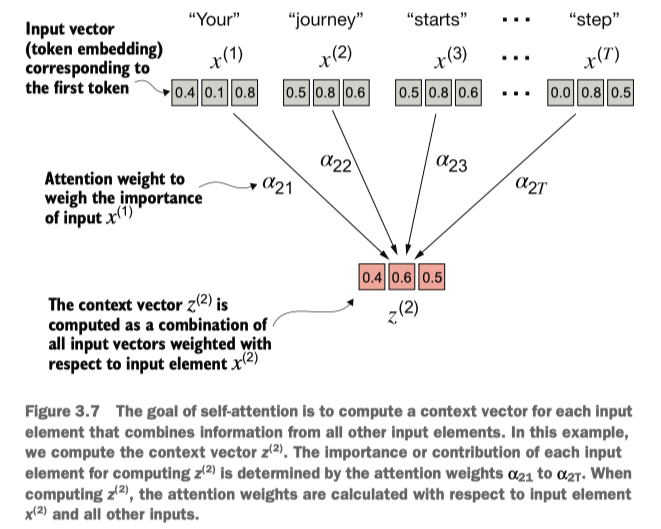


### Steps

### **Step 1:**

- compute unnormalized attention scores $\omega$
- Suppose we use the second input token as the query, that is, $q^{(2)} = x^{(2)}$, we compute the unnormalized attention scores via dot products:
    - $\omega_{21} = x^{(1)} q^{(2)\top}$
    - $\omega_{22} = x^{(2)} q^{(2)\top}$
    - $\omega_{23} = x^{(3)} q^{(2)\top}$
    - ...
    - $\omega_{2T} = x^{(T)} q^{(2)\top}$

 **在注意力机制中，点积的作用是 计算“查询（Query）”和“键（Key）”的相似度，从而决定模型应该对输入的哪部分分配更多注意力。**

- Above, $\omega$ used to symbolize the unnormalized attention scores
    - The subscript "21" in $\omega_{21}$ means that input sequence element 2 was used as a query against input sequence element 1

In [2]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

1. The primary objective of this section is to demonstrate how the context vector $z^{(2)}$ is calculated using the second input sequence, $x^{(2)}$, as a query.

2. The figure depicts the initial step in this process, which involves calculating the attention scores ω between $x^{(2)}$ and all other input elements through a dot product operation

3. We use input sequence element 2, $x^{(2)}$, as an example to compute context vector $z^{(2)}$; later in this section, we will generalize this to compute all context vectors.
4. The first step is to compute the unnormalized attention scores by computing the dot product between the query $x^{(2)}$ and all other input tokens:

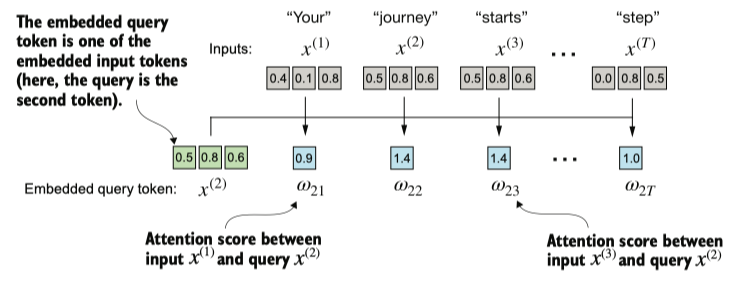

In [3]:
query = inputs[1] # second input token is the query

attn_scores_2 =torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [6]:
# Note: a dot product is essentially a shorthand for multiplying two vectors elements-wise and summing the resulting products:

res =0

for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]

print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


### **Step 2:**

- Normalize the unnormalized attention scores ("omegas", $\omega$) so that they sum up to 1

- Here is a simple way to normalize the unnormalized attention scores to sum up to 1:

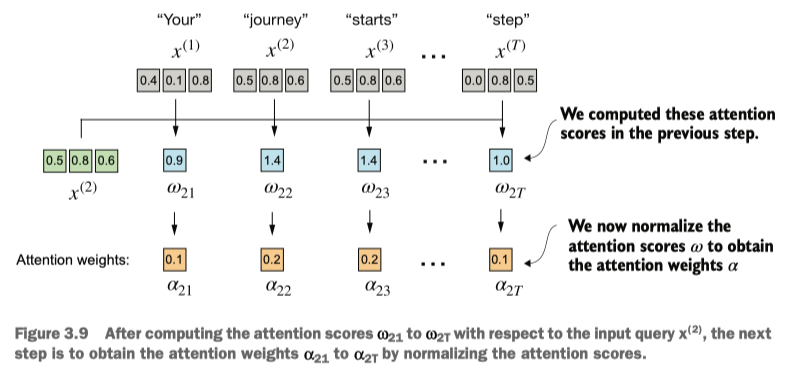

In [8]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


However, in practice, using the **softmax function** for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended.

Here's a naive implementation of a softmax function for scaling, which also normalizes the vector elements such that they sum up to 1:

In [9]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


### **Step 3**:

Compute the context vector $z^{(2)}$ by multiplying the embedded input tokens, $x^{(i)}$ with the attention weights and sum the resulting vectors:


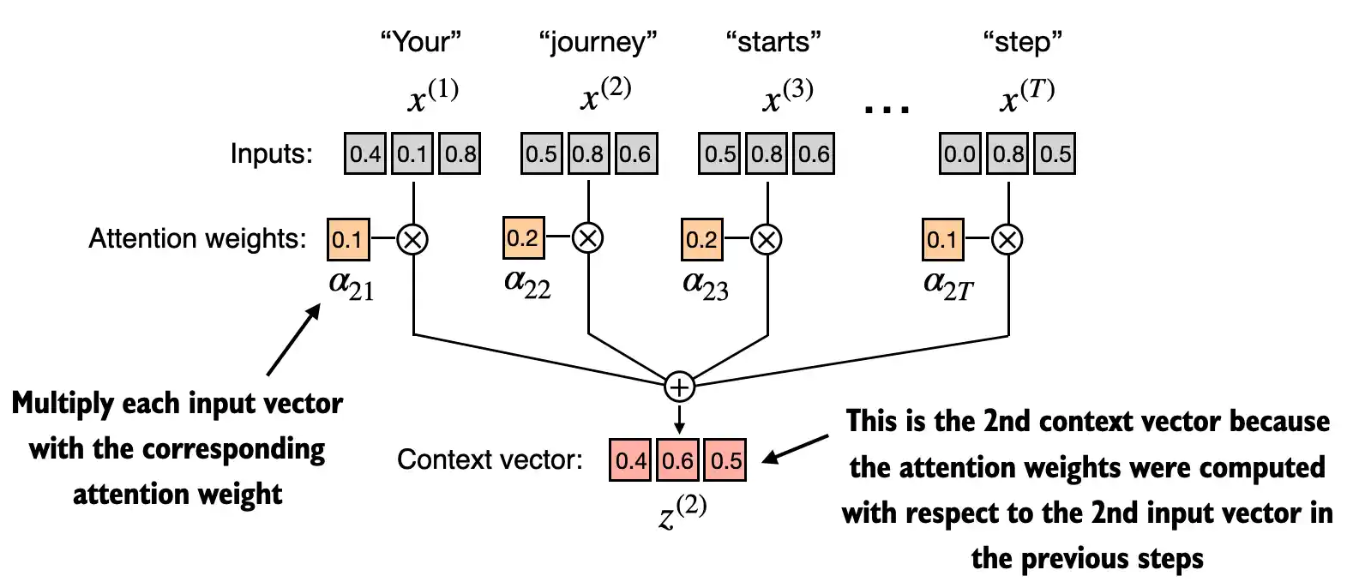

In [10]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


## Computing attention weights for all input tokens

Next, we are generalizing this computation to compute all attention weights and context vectors.

1. Compute attention scores
    - Compute the attention scores as dot products between the inputs
2. Compute attention weights
    - The attention weights are a normalized version of the attention scores
3. Compute context vectors
    - The context vectors are computed as a weighted sum over the inputs

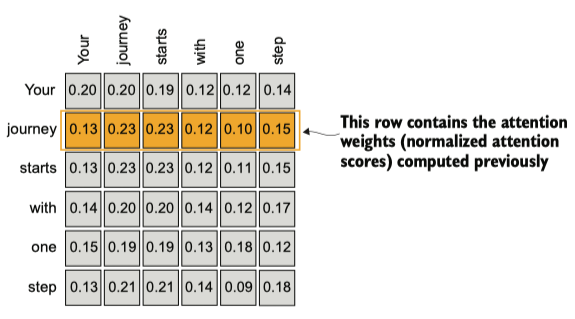

In [11]:
atten_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        atten_scores[i, j] = torch.dot(x_i, x_j)

print(atten_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [14]:
# We can achieve the same as above more efficiently via matrix multiplication:

attn_scores = inputs @ inputs.T

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [15]:
# normalize each row so that the values in each row sum to 1:

attn_weights = torch.softmax(attn_scores, dim=-1)

print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [16]:
# Quick verification that the values in each row indeed sum to 1:

row_2_sum = sum([0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452])

print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 0.9999
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [17]:
all_context_vecs = attn_weights @ inputs

print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


# Implementing self-attention with trainable weights

## Computing the attention weights step by step

## Step 1:

- This self-attention mechanism is also called "scaled dot-product attention"
- The overall idea is similar to before:
  - We want to compute context vectors as weighted sums over the input vectors specific to a certain input element
  - For the above, we need attention weights
- As you will see, there are only slight differences compared to the basic attention mechanism introduced earlier:
  - The most notable difference is the introduction of weight matrices that are updated during model training
  - These trainable weight matrices are crucial so that the model (specifically, the attention module inside the model) can learn to produce "good" context vectors


  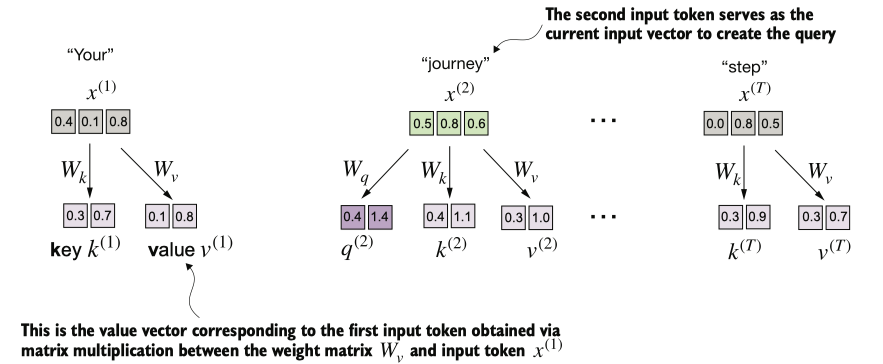


In the first step of the self-attention mechanism with trainable weight matrices, we compute query (q), key (k), and value (v) vectors for input elements x. Similar to previous sections, we designate the second input, $x^{(2)}$ , as the query input. The query vector $q^{(2)}$ is obtained via matrix multiplication between the input $x^{(2)}$ and the weight matrix $W_{(q)}$. Similarly, we obtain the key and value vectors via matrix multiplication involving the weight matrices $W_{(k)}$ and $W_{(v)}$ .

- Implementing the self-attention mechanism step by step, we will start by introducing the three training weight matrices $W_q$, $W_k$, and $W_v$
- These three matrices are used to project the embedded input tokens, $x^{(i)}$, into query, key, and value vectors via matrix multiplication:

  - Query vector: $q^{(i)} = W_q \,x^{(i)}$
  - Key vector: $k^{(i)} = W_k \,x^{(i)}$
  - Value vector: $v^{(i)} = W_v \,x^{(i)}$

- The embedding dimensions of the input $x$ and the query vector $q$ can be the same or different, depending on the model's design and specific implementation
- In GPT models, the input and output dimensions are usually the same, but for illustration purposes, to better follow the computation, we choose different input and output dimensions here:

In [18]:
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

Below, we **initialize the three weight matrices**; note that we are setting requires_grad=False to reduce clutter in the outputs for illustration purposes, but if we were to **use the weight matrices for model training, we would set requires_grad=True** to update these matrices during model training

In [20]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [21]:
# compute the query, key and value vectors

query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


In [22]:
# projected the 6 input tokens from a 3D onto a 2D embedding space:

keys = inputs @ W_key
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


## Step 2:

Compute the unnormalized attention scores by computing the dot product between the query and each key vector:

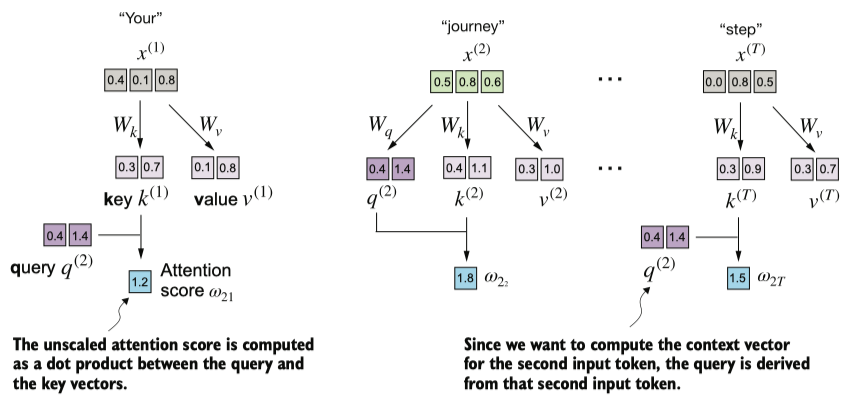


The attention score computation is a dot-product computation similar to what we used in the simplified self-attention mechanism. The new aspect here is that we are not directly computing the dot-product between the input elements but using the query and key obtained by transforming the inputs via the respective weight matrices.

In [23]:
keys_2 = keys[1]

attn_scores_22 = query_2.dot(keys_2)

print(attn_scores_22)

tensor(1.8524)


In [26]:
 # 6 inputs, we have 6 attention scores for the given query vector:

 attn_scores_2 = query_2 @ keys.T

print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


## Step 3:

- Compute the attention weights (normalized attention scores that sum up to 1) using the softmax function we used earlier

- - The difference to earlier is that we now scale the attention scores by dividing them by the square root of the embedding dimension, $\sqrt{d_k}$ (i.e., `d_k**0.5`):

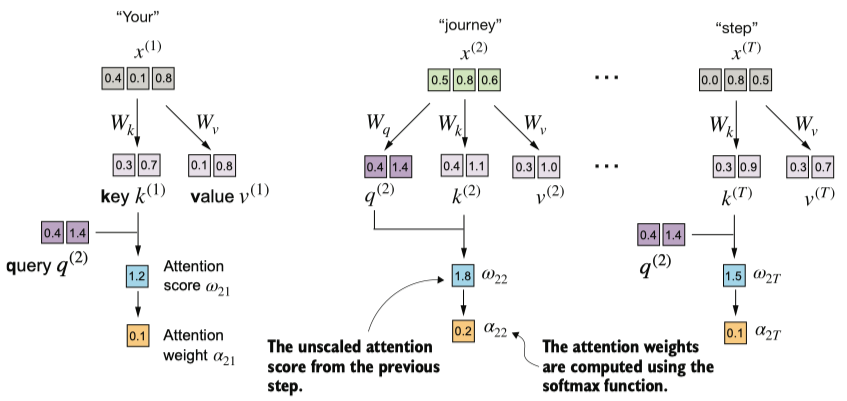

In [27]:
d_k = keys.shape[1]

attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)

print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


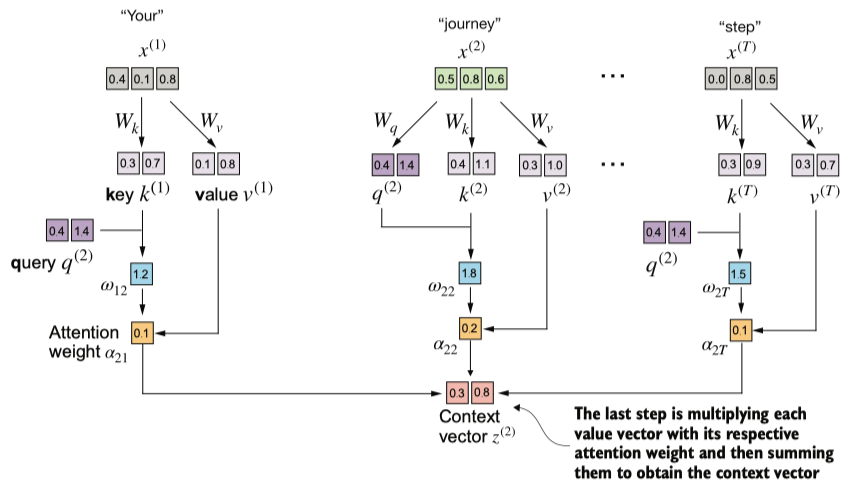

## Step 4:

Compute the context vector for input query vector 2:

In [29]:
context_vec_2 = attn_weights_2 @ values

print(context_vec_2)

tensor([0.3061, 0.8210])



### Why query, key, and value?

A query is analogous to a search query in a database. It represents the current item (e.g., a word or token in a sentence) the model focuses on or tries to understand. The query is used to probe the other parts of the input sequence to determine how much attention to pay to them.

The key is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key. These keys are used to match the query.

The value in this context is similar to the value in a key-value pair in a database. It represents the actual content or representation of the input items. Once the model determines which keys (and thus which parts of the input) are most relevant to the query (the current focus item), it retrieves the corresponding values.

- Query：你在找什么？
- Key：备选项的标签。
- Value：备选项的实际内容。


###为什么需要Q、K、V？
- Key和Value可以不同（比如Key是词的表层特征，Value是深层语义）。
- 允许模型区分“匹配依据”（Key）和“实际提供的信息”（Value）。

注意力机制就是 **"用Query匹配Key，再取对应的Value"**

### Implement a compact SelfAttention class

In [30]:
import torch.nn as nn

# nn.Module, which is a fundamental building block of PyTorch models
# that provides necessary functionalities for model layer creation and management.

class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.randn(d_in, d_out))
        self.W_key = nn.Parameter(torch.randn(d_in, d_out))
        self.W_value = nn.Parameter(torch.randn(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T # omega  注意力分数矩阵（通常是Query和Key的点积结果）

        # dim=-1表示对最后一个维度做Softmax：若 attn_scores 形状是 [batch_size, num_queries, num_keys]，则对 num_keys 维度归一化。即：每个Query对所有Keys的分数归一化
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1) # keys.shape[-1]:Key向量的维度（比如64维）

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))


tensor([[0.2845, 0.4071],
        [0.2854, 0.4081],
        [0.2854, 0.4075],
        [0.2864, 0.3974],
        [0.2863, 0.3910],
        [0.2860, 0.4039]], grad_fn=<MmBackward0>)


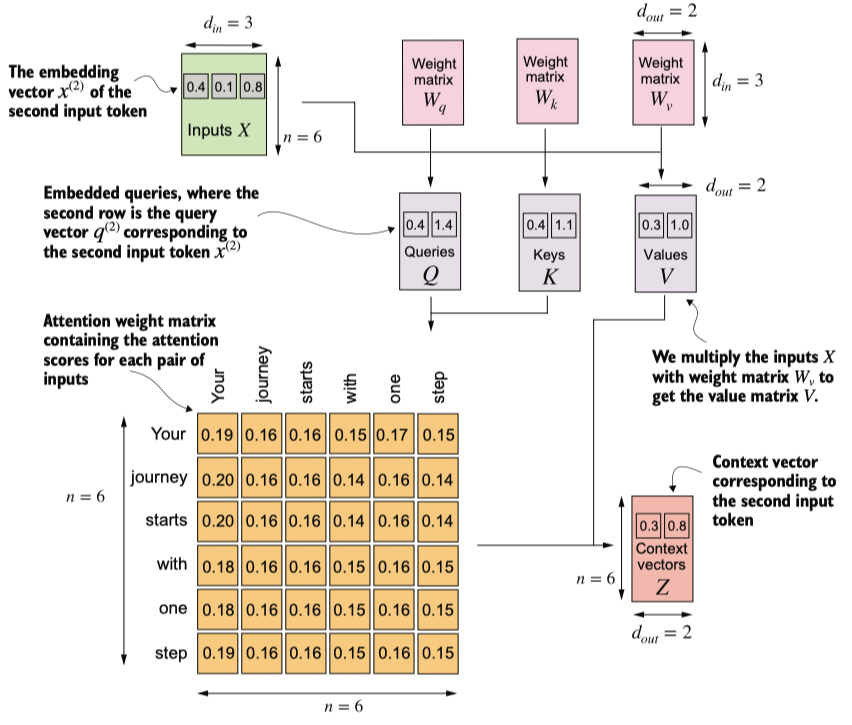

In self-attention, we transform the input vectors in the input matrix $X$ with the three weight matrices, $W_q$ , $W_k$ , and $W_v$ . The new compute the attention weight matrix based on the resulting queries (Q) and keys (K). Using the attention weights and values (V), we then compute the context vectors (Z).

For visual clarity, we focus on a single input text with $n$ tokens, not a batch of multiple inputs. Consequently, the three-dimensional input tensor is simplified to a two-dimensional matrix in this context. This approach allows for a more straightforward visualization and understanding of the processes involved. For consistency with later figures, the values in the attention matrix do not depict the real attention weights. (The numbers in this figure are truncated to two digits after the decimal point to reduce visual clutter. The values in each row should add up to 1.0 or 100%.)

- We can streamline the implementation above using PyTorch's Linear layers, which are equivalent to a matrix multiplication if we disable the bias units
- Another big advantage of using `nn.Linear` over our manual `nn.Parameter(torch.rand(...)` approach is that `nn.Linear` has a preferred weight initialization scheme, which leads to more stable model training

In [31]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


# Hiding future words with causal attention

In causal attention, the attention weights above the diagonal are masked, ensuring that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the attention weight.

## Applying a causal attention mask
- Causal self-attention ensures that the model's prediction for a certain position in a sequence is only dependent on the known outputs at previous positions, not on future positions
- In simpler words, this ensures that each next word prediction should only depend on the preceding words
- To achieve this, for each given token, we mask out the future tokens (the ones that come after the current token in the input text):

In [33]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the previous section for convenience

queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)

attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


- The simplest way to mask out future attention weights is by creating a mask via PyTorch's tril function with elements below the main diagonal (including the diagonal itself) set to 1 and above the main diagonal set to 0:
- torch.ones(context_length, context_length)：
生成一个全1的方阵（尺寸=[context_length, context_length]）。

- torch.tril()：
保留矩阵的下三角部分（包含对角线），上三角部分置0。

In [34]:
context_length = attn_scores.shape[0]

# 生成一个下三角矩阵（lower triangular matrix
mask_simple = torch.tril(torch.ones(context_length, context_length))

print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Then, we can multiply the attention weights with this mask to zero out the attention scores above the diagonal:

In [36]:
masked_simple = attn_weights*mask_simple

print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


- However, if the **mask were applied after softmax**, like above, it would disrupt the probability distribution created by softmax
- Softmax ensures that all output values sum to 1
- Masking after softmax would require re-normalizing the outputs to sum to 1 again, which complicates the process and might lead to unintended effects

- To make sure that the rows sum to 1, we can normalize the attention weights as follows:

In [37]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)

masked_simple_norm = masked_simple / row_sums

print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


In [38]:
# torch.triu(..., diagonal=1)：保留矩阵的上三角部分（不包含对角线），其余位置置0。

mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)

print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [39]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)

print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


### Masking additional attention weights with dropout

- Dropout can be applied in several places:
  - for example, after computing the attention weights;
  - or after multiplying the attention weights with the value vectors
- Here, we will apply the dropout mask after computing the attention weights because it's more common

- Furthermore, in this specific example, we use a dropout rate of 50%, which means randomly masking out half of the attention weights.
- When we train the GPT model later, we will use a lower dropout rate, such as 0.1 or 0.2

**Note:**
- If we apply a dropout rate of 0.5 (50%), the non-dropped values will be scaled accordingly by a factor of 1/0.5 = 2
- The scaling is calculated by the formula 1 / (1 - dropout_rate)

In [40]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))


tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [41]:
torch.manual_seed(123)

print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


## Implementing a compact causal self-attention class

Now, we are ready to implement a working implementation of self-attention, including the causal and dropout masks

**Note that dropout is only applied during training, not during inference**

In [42]:
# to simulate such batch inputs, we duplicate the input
# Two inputs with six tokens each; each token has embedding dimension 3.

batch = torch.stack((inputs, inputs), dim=0)

print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

torch.Size([2, 6, 3])


In [43]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.dropout = nn.Dropout(dropout) # New, add a dropout layer

        # 注册一个持久的注意力掩码（mask）“生成一个上三角矩阵作为注意力掩码，并注册为模型的固定属性，确保自回归模型不会作弊看到未来信息”
        # New, The register_buffer call is also a new addition, more information is provided in the following text).
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape # new batch dimension b; batch size（批大小）;token数量; embedding维度

        # For inputs where `num_tokens` exceeds `context_length`, this will result in errors
        # in the mask creation further below.
        # do not exceed `context_length` before reaching this forward method.
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)

        attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens],
            -torch.inf
        )

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)


tensor([[[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]],

        [[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


# multi-head attention

Stacking multiple single-head attention layers

- The main idea behind multi-head attention is to run the attention mechanism multiple times (in parallel) with different, learned linear projections. This allows the model to jointly attend to information from different representation subspaces at different positions.

In [44]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.5337, -0.1051,  0.5085,  0.3508],
         [-0.5323, -0.1080,  0.5084,  0.3508],
         [-0.5323, -0.1079,  0.5084,  0.3506],
         [-0.5297, -0.1076,  0.5074,  0.3471],
         [-0.5311, -0.1066,  0.5076,  0.3446],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.5337, -0.1051,  0.5085,  0.3508],
         [-0.5323, -0.1080,  0.5084,  0.3508],
         [-0.5323, -0.1079,  0.5084,  0.3506],
         [-0.5297, -0.1076,  0.5074,  0.3471],
         [-0.5311, -0.1066,  0.5076,  0.3446],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


In the implementation above, the embedding dimension is 4, because we d_out=2 as the embedding dimension for the key, query, and value vectors as well as the context vector. And since we have 2 attention heads, we have the output embedding dimension 2*2=4

### Implementing multi-head attention with weight splits


In [45]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- Note that in addition, we added a linear projection layer (self.out_proj ) to the MultiHeadAttention class above. This is simply a linear transformation that doesn't change the dimensions.

In [46]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In [47]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])
